In [2]:
%pip install yfinance stable-baselines3 gymnasium -q

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------------------- --------- 524.3/721.7 kB 330.7 kB/s eta 0:00:01
     -------------------------- --------- 524.3/721.7 kB 330.7 kB/s eta 0:00:01
     -------------------------- --------- 524.3/721.7 kB 330.7 kB/s eta 0:00:01
     -------------------------- --------- 524.3/721.7 kB 330.7 kB/s eta 0:00:01
     ------------------------------------ 721.7/721.7 kB 258.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finishe


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

RANDOM_SEED = 42
set_random_seed(RANDOM_SEED)

In [35]:
def load_btc_data(
    ticker: str = "BTC-USD",
    start: str = "2020-01-01",
    end: str = "2024-01-01",
) -> pd.DataFrame:
    # Explicit auto_adjust to control behavior
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)
    if df.empty:
        raise ValueError("Downloaded dataframe is empty. Check ticker or date range.")

    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
    df = df.dropna()

    # Simple returns
    df["Return"] = df["Close"].pct_change().fillna(0.0)
    df["LogReturn"] = np.log(df["Close"]).diff().fillna(0.0)

    # Volatility (14-day rolling std of log returns)
    df["Volatility"] = df["LogReturn"].rolling(14).std().fillna(0.0)

    # Simple moving averages
    df["SMA_10"] = df["Close"].rolling(10).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["SMA_10"] = df["SMA_10"].bfill()
    df["SMA_20"] = df["SMA_20"].bfill()

    # RSI (14) with 1D Series ops
    delta = df["Close"].diff()

    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)

    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()

    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    df["RSI_14"] = rsi.fillna(50.0)

    return df


df_raw = load_btc_data()
df_raw.tail()


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,Return,LogReturn,Volatility,SMA_10,SMA_20,RSI_14
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,
Date,,,,,,,,,,,
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,25260941032,0.021694,0.021462,0.019211,43274.542969,42928.051172,52.953577
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,22992093014,-0.018760,-0.018938,0.019908,43274.974609,42851.113867,48.025001
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,26000021055,-0.012397,-0.012474,0.018911,43257.862109,42769.784766,50.896402
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,16013925945,0.001366,0.001365,0.018806,43108.327344,42688.644922,49.548220
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,16397498810,0.002569,0.002565,0.017829,42947.930859,42739.712695,55.333275


In [36]:
def build_synthetic_text_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Short-term rolling return & volatility as a proxy
    roll_ret = df["Return"].rolling(5).mean().fillna(0.0)
    roll_vol = df["Volatility"].rolling(5).mean().fillna(df["Volatility"])

    # Sentiment in [-1, 1]
    sentiment_raw = roll_ret / (roll_vol + 1e-6)
    df["TextSentiment"] = np.tanh(sentiment_raw * 5.0)

    # Uncertainty in [0, 1]
    vol_min = df["Volatility"].min()
    vol_max = df["Volatility"].max()
    vol_norm = (df["Volatility"] - vol_min) / (vol_max - vol_min + 1e-8)
    df["TextUncertainty"] = np.clip(vol_norm, 0.0, 1.0)

    # Tiny synthetic embeddings (4D) – placeholder for real LLM embeddings
    np.random.seed(RANDOM_SEED)
    for i in range(4):
        df[f"emb_{i}"] = roll_ret + np.random.normal(scale=0.1, size=len(df))

    return df


df_feat = build_synthetic_text_features(df_raw)
df_feat[["Close", "Return", "Volatility", "TextSentiment", "TextUncertainty", "emb_0"]].head()


Price,Close,Return,Volatility,TextSentiment,TextUncertainty,emb_0
Ticker,BTC-USD,,,,,
Date,,,,,,
2020-01-01,7200.174316,0.000000,0.0,0.0,0.0,0.049671
2020-01-02,6985.470215,-0.029819,0.0,0.0,0.0,-0.013826
2020-01-03,7344.884277,0.051452,0.0,0.0,0.0,0.064769
2020-01-04,7410.656738,0.008955,0.0,0.0,0.0,0.152303
2020-01-05,7411.317383,0.000089,0.0,1.0,0.0,-0.017280


In [37]:
PRICE_FEATURE_COLS = ["Return", "LogReturn", "Volatility", "RSI_14"]
TEXT_FEATURE_COLS = ["TextSentiment", "TextUncertainty"] + [f"emb_{i}" for i in range(4)]

df_feat = df_feat.dropna().reset_index(drop=True)

train_ratio = 0.8
split_idx = int(len(df_feat) * train_ratio)

train_df = df_feat.iloc[:split_idx].reset_index(drop=True)
test_df = df_feat.iloc[split_idx:].reset_index(drop=True)

len(train_df), len(test_df)


(1168, 293)

In [44]:
class BitcoinTextHybridEnv(gym.Env):
    """
    Gymnasium-compatible environment:
    - observation_space: Box
    - action_space: Discrete(3) [0 = hold, 1 = long, 2 = close]
    - reset returns (obs, info)
    - step returns (obs, reward, terminated, truncated, info)
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        window_size: int = 30,
        initial_balance: float = 1000.0,
        transaction_cost: float = 0.001,
    ):
        super().__init__()

        self.df = df.reset_index(drop=True)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost

        self.price_cols = PRICE_FEATURE_COLS
        self.text_cols = TEXT_FEATURE_COLS

        self.n_price = len(self.price_cols)
        self.n_text = len(self.text_cols)

        # Actions: 0 = hold, 1 = long, 2 = close
        self.action_space = spaces.Discrete(3)

        obs_dim = self.window_size * (self.n_price + self.n_text) + 1  # + position flag
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

        # Internal state placeholders
        self.current_step = None
        self.balance = None
        self.position = None
        self.btc_amount = None
        self.equity = None
        self.equity_history = None

    def _get_price(self) -> float:
        return float(self.df["Close"].iloc[self.current_step].item())

    def _get_obs(self) -> np.ndarray:
        start = self.current_step - self.window_size
        end = self.current_step

        price_window = self.df[self.price_cols].iloc[start:end].values.flatten()
        text_window = self.df[self.text_cols].iloc[start:end].values.flatten()

        obs = np.concatenate(
            [price_window, text_window, np.array([self.position], dtype=np.float32)]
        )
        return obs.astype(np.float32)

    def reset(self, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)

        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.btc_amount = 0.0
        self.equity = self.initial_balance
        self.equity_history = [self.equity]

        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action: int):
        prev_equity = self.equity
        price = self._get_price()
        cost_factor = 1.0 - self.transaction_cost

        # Apply action
        if action == 1 and self.position == 0:
            # Go long with all balance
            if self.balance > 0:
                self.btc_amount = (self.balance * cost_factor) / price
                self.balance = 0.0
                self.position = 1

        elif action == 2 and self.position == 1:
            # Close long position
            gross_value = self.btc_amount * price
            net_value = gross_value * cost_factor
            self.balance = net_value
            self.btc_amount = 0.0
            self.position = 0

        # Move forward
        self.current_step += 1

        # Termination logic
        terminated = self.current_step >= len(self.df) - 1
        truncated = False  # no time-limit truncation here

        # Update equity
        self.equity = self.balance + self.btc_amount * self._get_price()
        self.equity_history.append(self.equity)

        reward = self.equity - prev_equity

        if terminated or truncated:
            obs = np.zeros_like(self._get_obs())
        else:
            obs = self._get_obs()

        info = {}
        return obs, float(reward), terminated, truncated, info

    def render(self):
        print(
            f"Step={self.current_step} | Equity={self.equity:.2f} | "
            f"Position={self.position} | BTC={self.btc_amount:.6f}"
        )


In [45]:
def make_train_env():
    return BitcoinTextHybridEnv(
        df=train_df,
        window_size=30,
        initial_balance=1000.0,
        transaction_cost=0.001,
    )

vec_env = DummyVecEnv([make_train_env])


In [46]:
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    seed=RANDOM_SEED,
)

model.learn(total_timesteps=50_000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 485  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010076436 |
|    clip_fraction        | 0.0651      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -6.35e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.6e+04     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00569    |
|    value_loss           | 4.21e+04    |
-----------------------------------------
-----------------

In [47]:
def run_agent(env: BitcoinTextHybridEnv, model: PPO):
    obs, info = env.reset()
    done = False
    equities = [env.equity]
    actions = []

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        done = terminated or truncated
        equities.append(env.equity)
        actions.append(int(action))

    return np.array(equities), np.array(actions)


def buy_and_hold_equity(df: pd.DataFrame, initial_balance: float = 1000.0, start_index: int = 30):
    prices = df["Close"].iloc[start_index:].values
    if len(prices) == 0:
        return np.array([initial_balance])

    btc_amount = initial_balance / prices[0]
    equity_curve = btc_amount * prices
    return equity_curve


def max_drawdown(equity_curve: np.ndarray) -> float:
    peaks = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - peaks) / (peaks + 1e-8)
    return float(drawdowns.min())


def sharpe_ratio(returns: np.ndarray, risk_free: float = 0.0) -> float:
    excess = returns - risk_free
    std = excess.std()
    if std < 1e-8:
        return 0.0
    return float(np.sqrt(252) * excess.mean() / (std + 1e-8))


In [48]:
test_env = BitcoinTextHybridEnv(
    df=test_df,
    window_size=30,
    initial_balance=1000.0,
    transaction_cost=0.001,
)

# Run RL agent
rl_equity, rl_actions = run_agent(test_env, model)

# Buy & Hold baseline
bh_equity = buy_and_hold_equity(
    df=test_df,
    initial_balance=1000.0,
    start_index=test_env.window_size,
)

# تبدیل هر دو به آرایه ۱بعدی مطمئن
rl_equity = np.asarray(rl_equity, dtype=float).reshape(-1)
bh_equity = np.asarray(bh_equity, dtype=float).reshape(-1)

# هم‌طول کردن‌شون
min_len = min(len(rl_equity), len(bh_equity))
rl_equity = rl_equity[:min_len]
bh_equity = bh_equity[:min_len]

# اگر خیلی کوتاه بود، از کرش جلوگیری کنیم
if min_len < 2:
    raise ValueError(f"Not enough points to compute returns (min_len={min_len}).")

# محاسبه بازده‌های روزانه
rl_returns = np.diff(rl_equity) / (rl_equity[:-1] + 1e-8)
bh_returns = np.diff(bh_equity) / (bh_equity[:-1] + 1e-8)

print("RL final equity:", rl_equity[-1])
print("BH final equity:", bh_equity[-1])
print("RL max drawdown:", max_drawdown(rl_equity))
print("BH max drawdown:", max_drawdown(bh_equity))
print("RL Sharpe:", sharpe_ratio(rl_returns))
print("BH Sharpe:", sharpe_ratio(bh_returns))

print("rl_equity shape:", rl_equity.shape)
print("bh_equity shape:", bh_equity.shape)

RL final equity: 1388.9545734147623
BH final equity: 1390.3449183330954
RL max drawdown: -0.20057773342719298
BH max drawdown: -0.20057773342719484
RL Sharpe: 1.1317235697437444
BH Sharpe: 1.1346733986760658
rl_equity shape: (263,)
bh_equity shape: (263,)


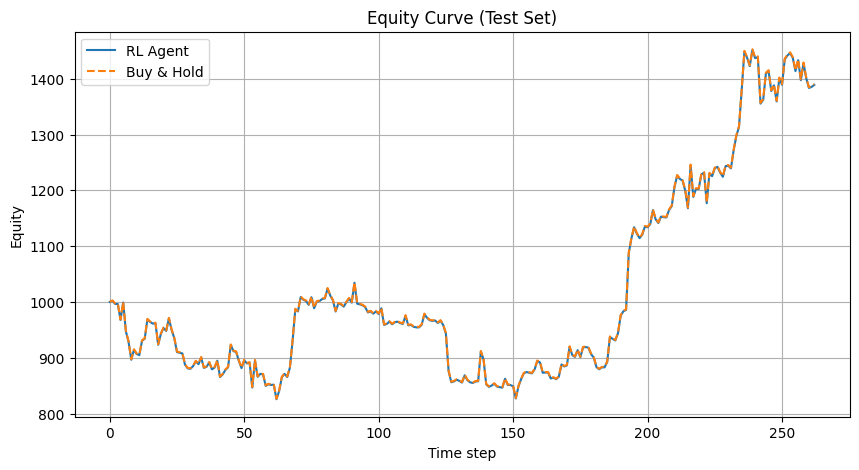

In [49]:
plt.plot(rl_equity, label="RL Agent")
plt.plot(bh_equity, "--", label="Buy & Hold")
plt.title("Equity Curve (Test Set)")
plt.xlabel("Time step")
plt.ylabel("Equity")
plt.legend()
plt.show()


In [50]:
unique, counts = np.unique(rl_actions, return_counts=True)
dict(zip(unique, counts))


{np.int64(1): np.int64(262)}